In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.fftpack import dct

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data_path = pd.read_csv("data_path.csv")

In [3]:
# I want to remove suprise and calm emotions from the dataset
data_path = data_path[(data_path.Emotions != 'calm') & (data_path.Emotions != 'surprise')]

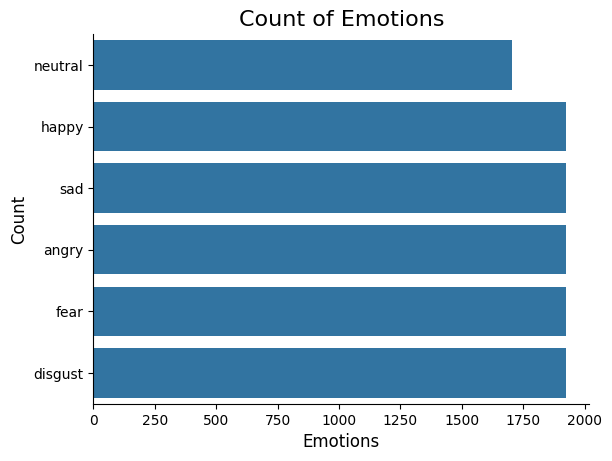

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
# Padding function
def pad_features(features, max_len=100):
    return pad_sequences(features, maxlen=max_len, padding='post', dtype='float32')

In [6]:
def extract_plp_features(audio_path, sr=16000, order=13):

    # Pre-emphasis
    pre_emphasis = 0.97
    emphasized_audio = np.append(audio_path[0], audio_path[1:] - pre_emphasis * audio_path[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01
    frame_length, frame_step = frame_size * sr, frame_stride * sr
    signal_length = len(emphasized_audio)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)) + 1
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_audio, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(
        np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # Windowing
    # frames *= np.hamming(frame_length)
    frames *= np.hanning(frame_length)
    # frames *= np.blackman(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 26
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sr)
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])
        f_m = int(bin[m])
        f_m_plus = int(bin[m + 1])
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    filter_banks = 20 * np.log10(filter_banks)

    # Cepstral Coefficients
    num_ceps = order
    cep_lifter = 22
    cepstral_coefficients = dct(filter_banks, type=2, axis=1, norm='ortho')[:, :num_ceps]

    # Liftering
    nframes, ncoeff = cepstral_coefficients.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    cepstral_coefficients *= lift

    return cepstral_coefficients

In [8]:
import numpy as np
import librosa

# Function to pad features to a fixed length
def pad_features(feature, max_len):
    if feature.shape[0] < max_len:
        # Padding along the sequence dimension (axis 0)
        pad_width = max_len - feature.shape[0]
        feature = np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')
    else:
        # Trim if it's longer than max_len
        feature = feature[:max_len, :]
    return feature

X_combined, Y = [], []
max_len = 100  # Set the desired maximum length for each sequence

for path, emotion in zip(data_path.Path, data_path.Emotions):
    data, sample_rate = librosa.load(path)
    
    # Extract MFCC and PLP features
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T
    plp = extract_plp_features(data, sr=sample_rate)
    
    # Pad MFCC and PLP to the same length (max_len)
    mfcc = pad_features(mfcc, max_len=max_len)
    plp = pad_features(plp, max_len=max_len)
    
    # Concatenate MFCC and PLP features along the feature dimension (axis 1)
    combined_features = np.concatenate((mfcc, plp), axis=1)

    # Append to lists
    X_combined.append(combined_features)
    Y.append(emotion)
    
# Convert lists to NumPy arrays
X_combined = np.array(X_combined)
Y = np.array(Y)

# Save X and Y as .npy files
np.save('Combined_X_features.npy', X_combined)
np.save('Combined_Y_labels.npy', Y)


In [5]:
# Load saved X and Y
X = np.load('Combined_X_features.npy', allow_pickle=True)
Y = np.load('Combined_Y_labels.npy', allow_pickle=True)

In [6]:
# I want a list that has the unique emotions
unique_emotions = data_path.Emotions.unique()
# unique_emotions
# convert to list
unique_emotions = list(unique_emotions)
unique_emotions

['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']

In [7]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()

# Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
encoded_labels = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [8]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.3, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7922, 100, 26), (7922, 6), (3396, 100, 26), (3396, 6))

In [9]:
x_train.shape[2]

26

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense,GlobalMaxPooling1D, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2

def build_model(x_train, y_train, x_test, y_test, num_classes):
    
    input_shape = (100, x_train.shape[2])
    audio_model = Sequential([
        
        Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01), padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        
        # Bidirectional(LSTM(128, return_sequences=True)),
        # Dropout(0.2),
        
        # Bidirectional(LSTM(64)),
        # Dropout(0.2),
        
        GlobalMaxPooling1D(),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    audio_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = audio_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, mode='min', restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
    ])

    # Evaluate the model on the test set
    loss, accuracy = audio_model.evaluate(x_test, y_test)
    print(f"Audio Model Test Accuracy: {accuracy * 100:.2f}%")

    return audio_model, history

# Train the audio model with pre-extracted features
audio_model, history = build_model(x_train, y_train, x_test, y_test, num_classes=6)


Epoch 1/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.1998 - loss: 5.4248 - val_accuracy: 0.3375 - val_loss: 3.6024
Epoch 2/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.2837 - loss: 3.7355 - val_accuracy: 0.3993 - val_loss: 3.4431
Epoch 3/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3129 - loss: 3.5061 - val_accuracy: 0.4311 - val_loss: 3.3008
Epoch 4/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3611 - loss: 3.3521 - val_accuracy: 0.4529 - val_loss: 3.1684
Epoch 5/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3716 - loss: 3.2350 - val_accuracy: 0.4679 - val_loss: 3.0504
Epoch 6/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3982 - loss: 3.1248 - val_accuracy: 0.4732 - val_loss: 2.9513
Epoch 7/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4251 - loss: 3.0037 - val_accuracy: 0.4800 - val_loss: 2.8583
Epoch 8/100
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.4397 - loss: 2.9087 -

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


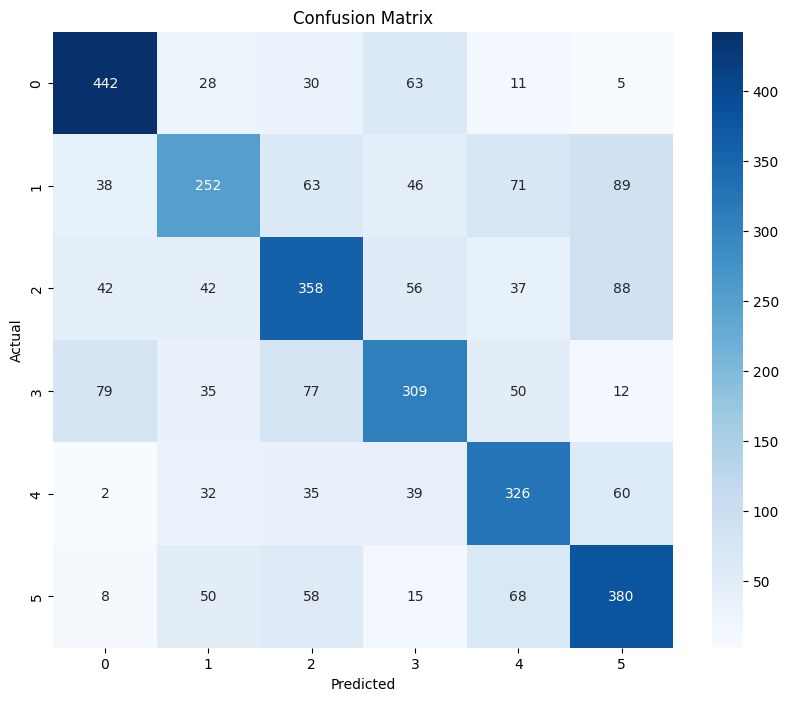

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Assuming `Y` is the original list of labels (before one-hot encoding)
# Fit the LabelEncoder on the original labels
label_encoder = LabelEncoder()
label_encoder.fit(np.argmax(y_train, axis=1))  # Fit LabelEncoder on the integer-encoded classes

# Since `y_test` is one-hot encoded, convert it back to the original class labels
y_true = np.argmax(y_test, axis=1)

# Predict the labels for the test set
y_pred = audio_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions from one-hot encoding to class labels

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Get the unique class labels using the fitted label encoder
class_labels = label_encoder.classes_

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred_classes, class_labels=class_labels)


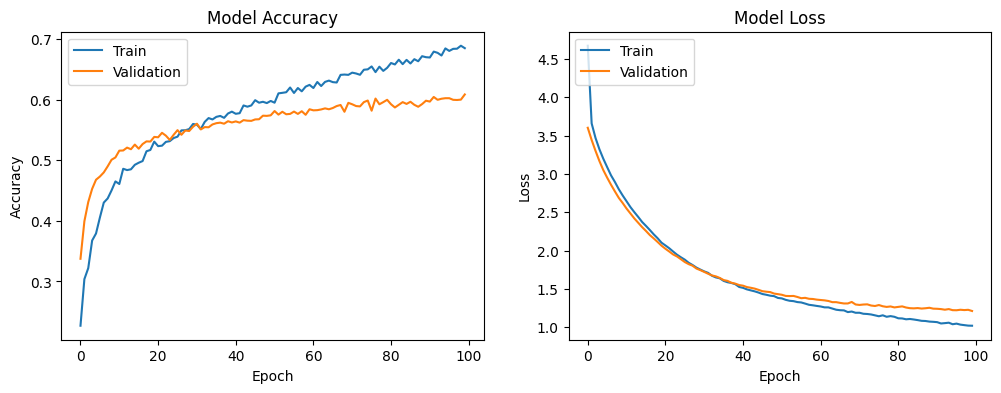

In [12]:
import matplotlib.pyplot as plt

# Function to plot the training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Plot the training history
plot_training_history(history)
